In [2]:
# !pip3 install pandas
# !pip3 install matplotlib
# !pip3 install statsmodels
# !pip3 install catboost
# !pip3 install openpyxl
# !pip3 install scikit-learn

In [3]:
import pandas as pd

# Загрузка данных
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

# Сортировка по дате
train = train.sort_values('dt').reset_index(drop=True)
test = test.sort_values('dt').reset_index(drop=True)

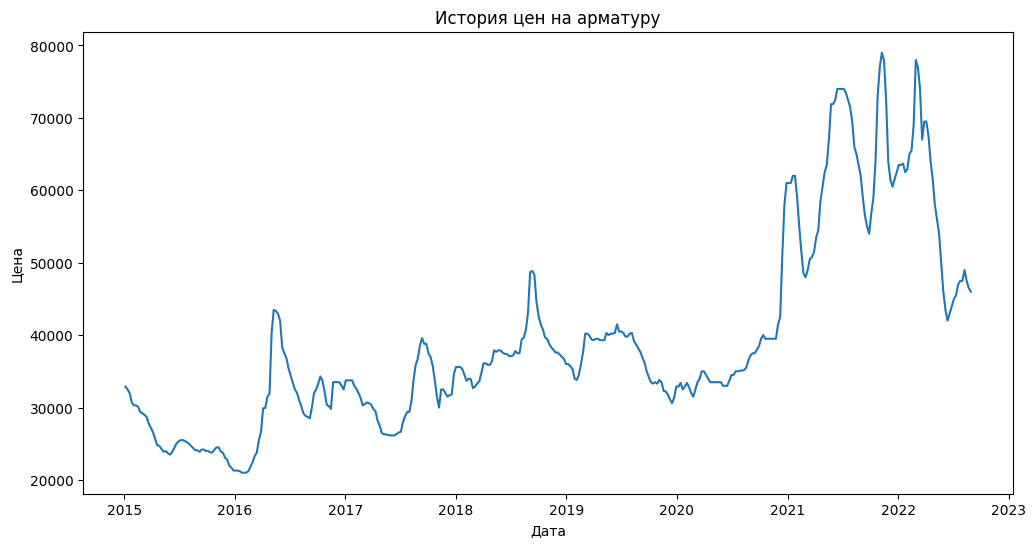

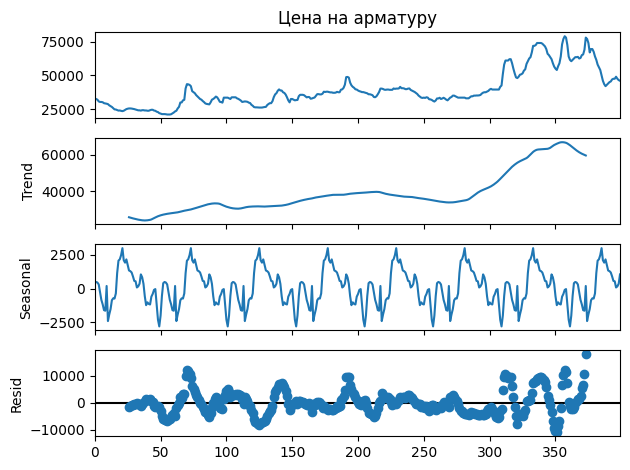

In [4]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# График цен
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], train['Цена на арматуру'])
plt.title('История цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

# Декомпозиция ряда
result = seasonal_decompose(train['Цена на арматуру'], model='additive', period=52)
result.plot()
plt.show()

Генерируем признаки. Создаем лаги для того, чтобы создались цены за прошлые недели(1 - за прошлую, 2- за прошлую и т.д.). Также добавляем скользящее среднее за 8 недель и календарные признаки, которые будут давать понять о сезонности и тренде.

In [5]:
# Создание лагов
for lag in [1, 2, 3, 4]:
    train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)

# Скользящее среднее за 8 недель
train['Скользящее среднее'] = train['Цена на арматуру'].rolling(window=8).mean()

# Календарные признаки
train['week'] = train['dt'].dt.isocalendar().week
train['month'] = train['dt'].dt.month

In [6]:
train.head()

,dt,Цена на арматуру,lag_1,lag_2,lag_3,lag_4,Скользящее среднее,week,month
0,2015-01-05,32900,NaN,NaN,NaN,NaN,NaN,2,1
1,2015-01-12,32500,32900.0,NaN,NaN,NaN,NaN,3,1
2,2015-01-19,32000,32500.0,32900.0,NaN,NaN,NaN,4,1
3,2015-01-26,30700,32000.0,32500.0,32900.0,NaN,NaN,5,1
4,2015-02-02,30300,30700.0,32000.0,32500.0,32900.0,NaN,6,2


In [7]:
test.head()

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500


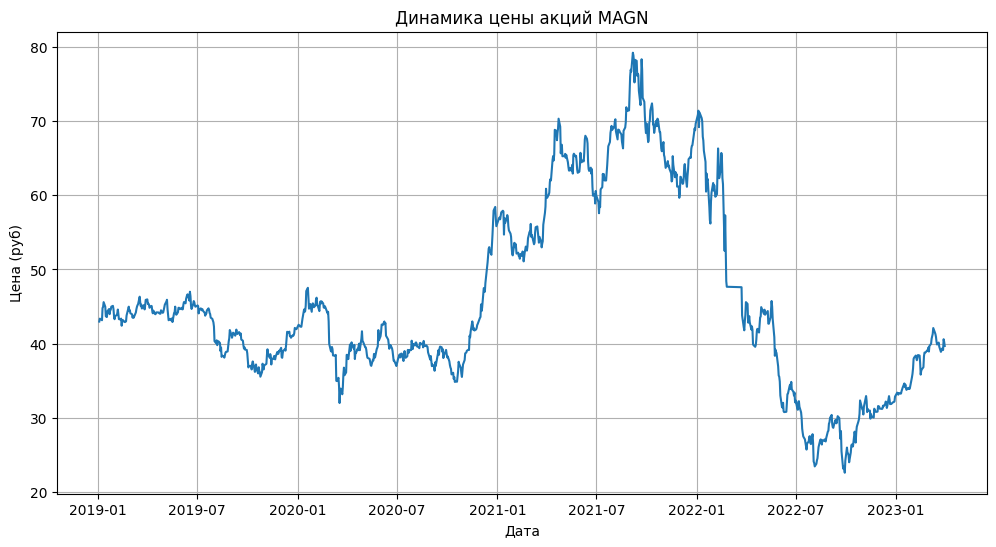

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv("excel_files/MAGN Акции.csv", parse_dates=["Дата"], dayfirst=True)

# График цены закрытия
plt.figure(figsize=(12, 6))
plt.plot(df["Дата"], df["Цена"].str.replace(",", ".").astype(float))
plt.title("Динамика цены акций MAGN")
plt.xlabel("Дата")
plt.ylabel("Цена (руб)")
plt.grid()
plt.show()

In [9]:
gruzoperevoski = pd.read_excel('excel_files/Грузоперевозки.xlsx')
gruzoperevoski.head()

,dt,Индекс стоимости грузоперевозок
0,2017-09-06,1000
1,2017-09-13,991
2,2017-09-20,992
3,2017-09-27,979
4,2017-10-04,985


In [10]:
data_from_market = pd.read_excel('excel_files/Данные рынка стройматериалов.xlsx')
data_from_market.head()

,dt,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,Потребление цемента,Отгрузка цемента,Цена цемента с НДС,Цена цемента без НДС,Производство бетона РФ,Производство бетона МО,Производство бетона СПБ
0,2021-04-30,40.751,27.530,987.540,201.757,2.3891,52.331737,31.49115,2.290941,1.189297,3769.20,4968.10,1.919781,223.405,198.589
1,2021-05-31,69.979,43.423,1071.832,256.733,2.7115,79.639340,50.16415,2.670775,1.328565,3745.23,4822.46,2.059197,293.411,162.181
2,2021-06-30,105.525,58.226,1495.351,446.953,3.8468,125.590100,64.99075,3.984199,1.942304,3790.64,5299.51,2.837929,424.112,254.893
3,2021-07-31,125.093,88.930,1754.576,573.133,4.8559,182.176201,105.96590,4.933510,2.327709,3853.30,5031.96,3.302281,492.623,301.091
4,2021-08-31,124.438,112.454,1859.549,659.929,5.7240,193.681060,141.09315,5.762688,2.519478,3915.07,5240.72,3.788132,562.724,303.961


In [11]:
index_LME = pd.read_excel('excel_files/Индекс LME.xlsx')
index_LME.columns = ["dt", "price"]
index_LME.head()

,dt,price
0,2021-02-12,607
1,2021-02-15,614
2,2021-02-16,615
3,2021-02-17,606
4,2021-02-18,604


In [12]:
Makropokozateli = pd.read_excel('excel_files/Макропоказатели.xlsx')
Makropokozateli.head()

,dt,Базовый индекс потребительских цен на товары и услуги,Ключевая ставка,Курс доллара
0,2016-01-31,NaN,NaN,NaN
1,2016-02-29,NaN,NaN,NaN
2,2016-03-31,NaN,NaN,NaN
3,2016-04-30,NaN,NaN,NaN
4,2016-05-31,NaN,NaN,NaN


In [13]:
Makropokozateli['Базовый индекс потребительских цен на товары и услуги'] = Makropokozateli['Базовый индекс потребительских цен на товары и услуги'].fillna(0)

mean_value = Makropokozateli['Ключевая ставка'].mean()
Makropokozateli['Ключевая ставка'] = Makropokozateli['Ключевая ставка'].fillna(mean_value)

mean_value1 = Makropokozateli['Курс доллара'].mean()
Makropokozateli['Курс доллара'] = Makropokozateli['Курс доллара'].fillna(mean_value1)


In [14]:
pokawateli_rinka_metall = pd.read_excel('excel_files/Показатели рынка металла.xlsx')
pokawateli_rinka_metall.head()

,dt,Производство арматуры Сортовой прокат_Арматура,Производство арматуры Сортовой прокат_Катанка,Производство арматуры Сортовой прокат_Прутки прочие,Производство сырья ЖРС_Агломерат,Производство сырья ЖРС_Аглоруда,Производство сырья ЖРС_Концентрат,Производство сырья ЖРС_Концентрат для дообогащения,Производство сырья ЖРС_Окатыши,Производство сырья Кокс_Кокс валовый,...,Экспорт сырья Лом_Лом стальной,Экспорт сырья Лом_Лом чугуна,Экспорт сырья Металлизованная продукция_Всего отгружено с предприятия,Экспорт сырья Металлизованная продукция_ГБЖ,Экспорт сырья Чугун_Всего отгружено с предприятия,Экспорт сырья Чугун_Литейный чугун,Экспорт сырья Чугун_Передельный чугун,Экспорт арматуры Сортовой прокат_Арматура,Экспорт арматуры Сортовой прокат_Катанка,Экспорт арматуры Сортовой прокат_Прутки прочие
0,2016-03-31,527,208,191,5127,376,9063,631,3691,2307,...,0,0,0,0,0,0,0,97,68,50
1,2016-04-30,563,231,216,4776,343,8850,608,3450,2297,...,0,0,0,0,0,0,0,118,79,55
2,2016-05-31,614,263,235,5107,420,9013,626,3849,2481,...,0,0,0,0,0,0,0,123,100,71
3,2016-06-30,659,242,237,4809,400,9275,613,3688,2372,...,0,0,0,0,0,0,0,129,78,61
4,2016-07-31,703,249,238,5147,420,9587,518,4032,2255,...,0,0,0,0,0,0,0,142,90,48


In [15]:
toplivo = pd.read_excel('excel_files/Топливо.xlsx')
toplivo.head()

,dt,Цена на бензин,Цена на дт
0,2017-02-28,35.91,36.15
1,2017-03-31,36.11,36.58
2,2017-04-30,36.41,36.69
3,2017-05-31,36.64,36.80
4,2017-06-30,36.91,36.87


In [16]:
price_for_raw = pd.read_excel('excel_files/Цены на сырье.xlsx')
price_for_raw.head()

,dt,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
0,2015-02-09,3850,228,12344,10009,12728,62,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-16,3850,206,12271,10432,12852,63,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-02-23,3850,207,12645,11981,13034,64,NaN,3700.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-02,3850,214,12696,11912,12910,63,NaN,3700.0,72.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN
4,2015-03-09,4400,232,12916,12061,12964,61,NaN,4050.0,70.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN


In [17]:
# Установка столбца 'dt' в качестве индекса
price_for_raw.set_index('dt', inplace=True)

# Убедимся, что индекс имеет тип datetime
price_for_raw.index = pd.to_datetime(price_for_raw.index)

# Заполнение пропущенных значений с помощью линейной интерполяции
price_for_raw = price_for_raw.interpolate(method='linear', limit_direction='forward')

# Заполнение оставшихся NaN в начале с помощью обратного заполнения (bfill)
price_for_raw = price_for_raw.fillna(method='bfill')

C:\Users\Darin_btw\AppData\Local\Temp\ipykernel_22116\3261450804.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_for_raw = price_for_raw.fillna(method='bfill')


In [18]:
price_for_raw.head()

,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т","Лом_3А, РФ CPT авто Центральный ФО, руб./т, без НДС",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
dt,,,,,,,,,,,,,,,,,,,,,
2015-02-09,3850,228,12344,10009,12728,62,285.5,3700.0,70.0,27450.0,...,18353.0,297.5,3540.0,2097.0,1261.0,23.0,64.0,101.0,77.0,125.5
2015-02-16,3850,206,12271,10432,12852,63,285.5,3700.0,70.0,27450.0,...,18353.0,297.5,3540.0,2097.0,1261.0,23.0,64.0,101.0,77.0,125.5
2015-02-23,3850,207,12645,11981,13034,64,285.5,3700.0,72.0,27450.0,...,18353.0,297.5,3540.0,2097.0,1261.0,23.0,64.0,101.0,77.0,125.5
2015-03-02,3850,214,12696,11912,12910,63,285.5,3700.0,72.0,27450.0,...,18353.0,297.5,3540.0,2097.0,1261.0,23.0,64.0,101.0,77.0,125.5
2015-03-09,4400,232,12916,12061,12964,61,285.5,4050.0,70.0,27450.0,...,18353.0,297.5,3540.0,2097.0,1261.0,23.0,64.0,101.0,77.0,125.5


In [19]:
CHMF_Akcii = pd.read_csv('excel_files/CHMF Акции.csv')
CHMF_Akcii.columns = ['dt', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
CHMF_Akcii.head()

,dt,Price,Open,High,Low,Vol.,Change %
0,03/31/2023,"1,043.20","1,061.00","1,061.00","1,042.00",571.72K,-1.68%
1,03/30/2023,"1,061.00","1,074.60","1,084.80","1,058.00",1.30M,-1.27%
2,03/29/2023,"1,074.60","1,040.60","1,078.40","1,035.40",1.79M,3.53%
3,03/28/2023,"1,038.00","1,041.40","1,044.00","1,033.00",269.09K,-0.17%
4,03/27/2023,"1,039.80","1,036.20","1,042.60","1,032.20",410.74K,0.50%


In [20]:
MAGN_Akcii = pd.read_csv('excel_files/MAGN Акции.csv')
MAGN_Akcii.columns = ['dt', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
MAGN_Akcii.head()

,dt,Price,Open,High,Low,Vol.,Change %
0,31.03.2023,"39,69","40,21","40,24","39,52","18,23M","-1,38%"
1,30.03.2023,"40,24","40,60","41,00","40,02","27,14M","-0,87%"
2,29.03.2023,"40,60","39,15","40,65","38,96","48,70M","3,70%"
3,28.03.2023,"39,15","39,45","39,75","38,91","17,02M","-0,62%"
4,27.03.2023,"39,40","38,99","39,48","38,92","20,95M","1,26%"


In [21]:
NLMK_Akcii = pd.read_csv('excel_files/NLMK Акции.csv')
NLMK_Akcii.columns = ['dt', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
NLMK_Akcii.head()

,dt,Price,Open,High,Low,Vol.,Change %
0,03/31/2023,129.32,130.60,130.60,128.36,3.54M,-0.98%
1,03/30/2023,130.60,132.30,133.44,129.80,4.85M,-0.94%
2,03/29/2023,131.84,128.00,134.44,127.10,10.37M,3.37%
3,03/28/2023,127.54,128.58,128.94,126.56,2.27M,-0.50%
4,03/27/2023,128.18,127.00,128.42,126.86,2.81M,1.33%


In [22]:
gruzoperevoski['dt'] = pd.to_datetime(gruzoperevoski['dt'], dayfirst=True)
train['dt'] = pd.to_datetime(train['dt'], dayfirst=True)
data_from_market['dt'] = pd.to_datetime(data_from_market['dt'], dayfirst=True)
index_LME['dt'] = pd.to_datetime(index_LME['dt'], dayfirst=True)
Makropokozateli['dt'] = pd.to_datetime(Makropokozateli['dt'], dayfirst=True)
pokawateli_rinka_metall['dt'] = pd.to_datetime(pokawateli_rinka_metall['dt'], dayfirst=True)
toplivo['dt'] = pd.to_datetime(toplivo['dt'], dayfirst=True)
# price_for_raw['dt'] = pd.to_datetime(price_for_raw['dt'], dayfirst=True)
CHMF_Akcii['dt'] = pd.to_datetime(CHMF_Akcii['dt'], dayfirst=True)
MAGN_Akcii['dt'] = pd.to_datetime(MAGN_Akcii['dt'], dayfirst=True)
NLMK_Akcii['dt'] = pd.to_datetime(NLMK_Akcii['dt'], dayfirst=True)

C:\Users\Darin_btw\AppData\Local\Temp\ipykernel_22116\2383052055.py:9: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  CHMF_Akcii['dt'] = pd.to_datetime(CHMF_Akcii['dt'], dayfirst=True)
C:\Users\Darin_btw\AppData\Local\Temp\ipykernel_22116\2383052055.py:11: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  NLMK_Akcii['dt'] = pd.to_datetime(NLMK_Akcii['dt'], dayfirst=True)


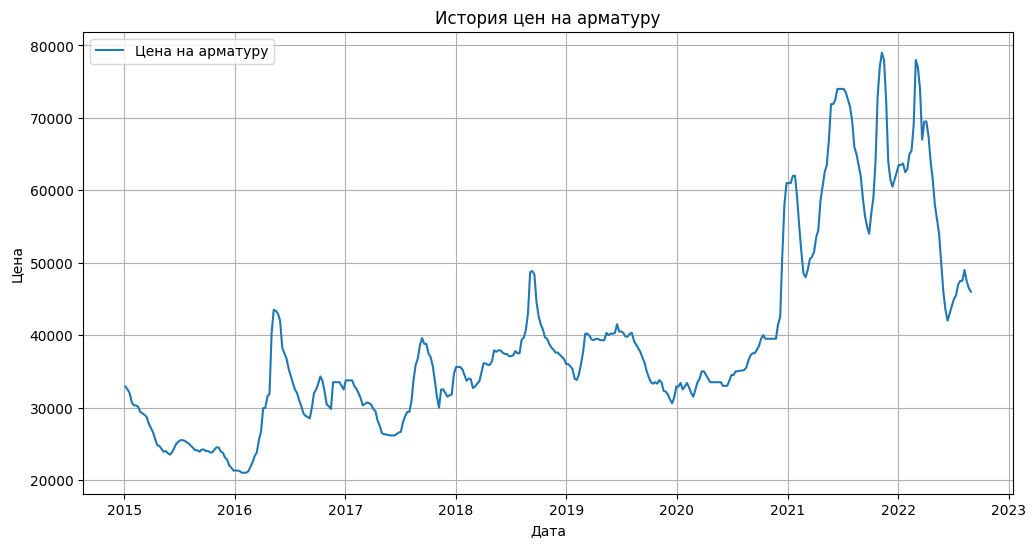

In [23]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Загрузка данных из файла train.xlsx
train_df = pd.read_excel('train.xlsx')
train_df['dt'] = pd.to_datetime(train_df['dt'])  # Преобразуем столбец даты в формат datetime
train_df.set_index('dt', inplace=True)  # Устанавливаем дату как индекс

# 1. Линейный график цен
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Цена на арматуру'], label='Цена на арматуру')
plt.title('История цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

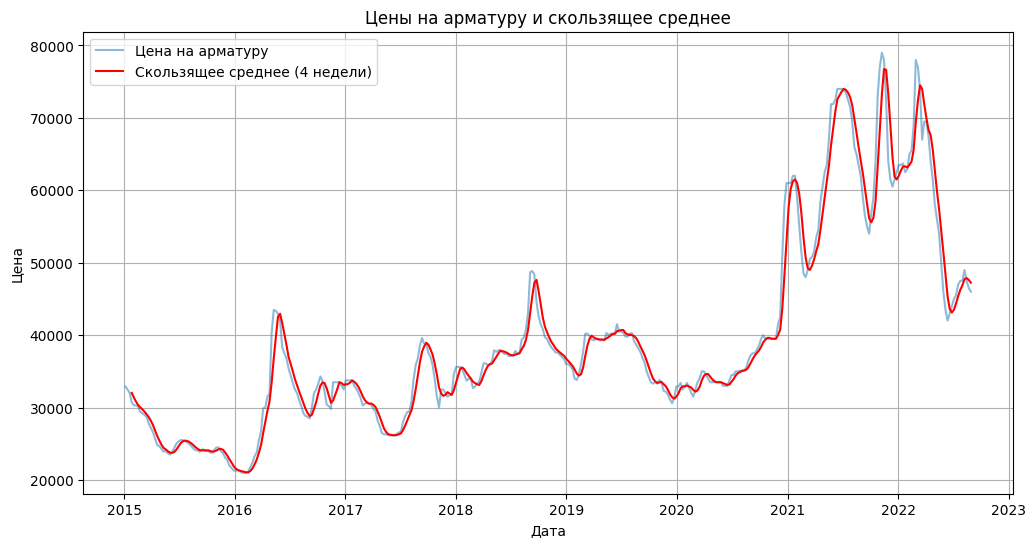

In [24]:
# 2. Скользящее среднее (4 недели)
train_df['ma_4'] = train_df['Цена на арматуру'].rolling(window=4).mean()  # Скользящее среднее за 4 недели
plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['Цена на арматуру'], label='Цена на арматуру', alpha=0.5)
plt.plot(train_df.index, train_df['ma_4'], label='Скользящее среднее (4 недели)', color='red')
plt.title('Цены на арматуру и скользящее среднее')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

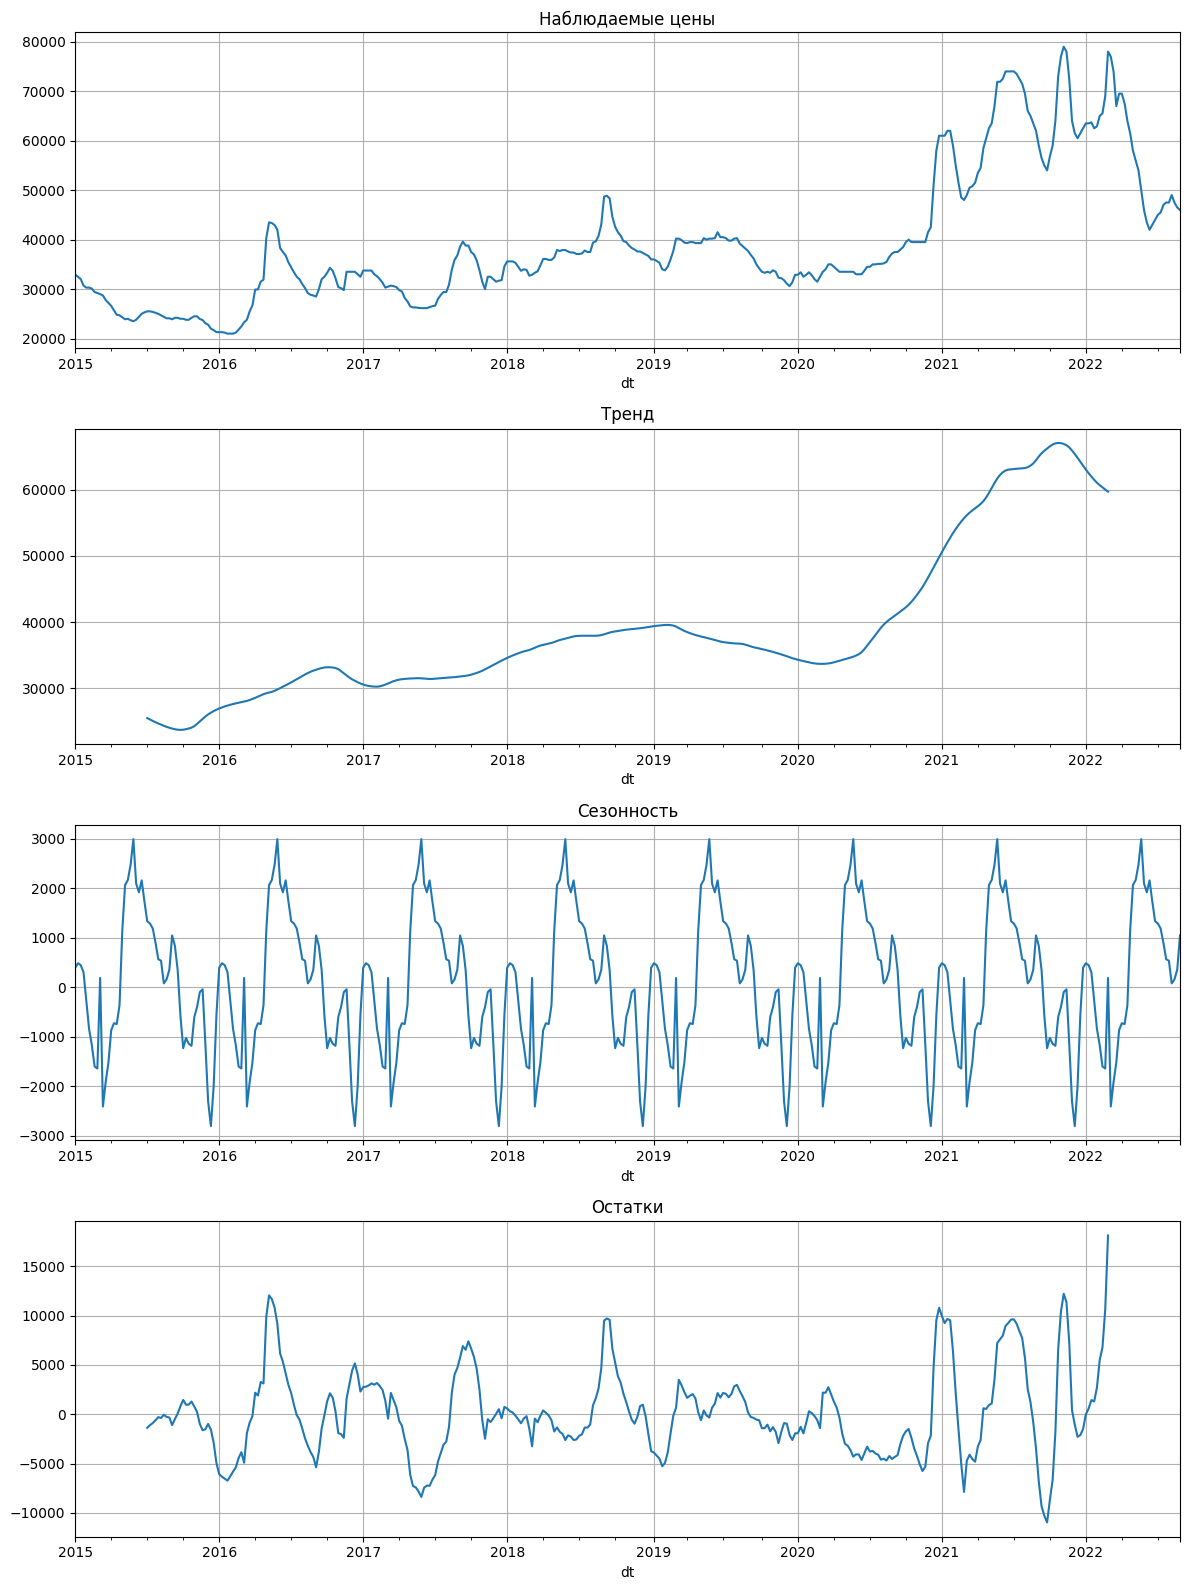

In [25]:
# 3. Сезонная декомпозиция
decomposition = seasonal_decompose(train_df['Цена на арматуру'], model='additive', period=52)  # Период 52 недели (год)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Наблюдаемые цены')
ax1.grid(True)
decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')
ax2.grid(True)
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')
ax3.grid(True)
decomposition.resid.plot(ax=ax4)
ax4.set_title('Остатки')
ax4.grid(True)
plt.tight_layout()
plt.show()

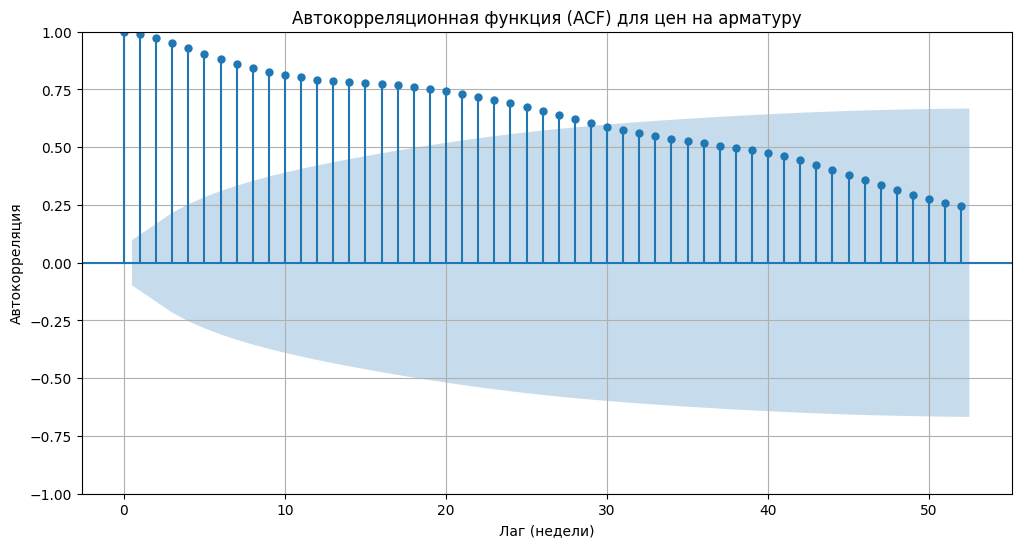

In [26]:
# 4. Автокорреляционная функция (ACF)
plt.figure(figsize=(12, 6))
plot_acf(train_df['Цена на арматуру'], lags=52, ax=plt.gca())  # Лаги до 52 недель
plt.title('Автокорреляционная функция (ACF) для цен на арматуру')
plt.xlabel('Лаг (недели)')
plt.ylabel('Автокорреляция')
plt.grid(True)
plt.show()

In [27]:
import pandas as pd

main_data = pd.read_excel('excel_files/Цены на сырье.xlsx')
main_data['dt'] = pd.to_datetime(main_data['dt'])
main_data.set_index('dt', inplace=True)

freight_data = pd.read_excel('excel_files/Грузоперевозки.xlsx')
freight_data['dt'] = pd.to_datetime(freight_data['dt'])
freight_data.set_index('dt', inplace=True)

construction_data = pd.read_excel('excel_files/Данные рынка стройматериалов.xlsx')
construction_data['dt'] = pd.to_datetime(construction_data['dt'])
construction_data.set_index('dt', inplace=True)
construction_data_weekly = construction_data.resample('W-MON').ffill()

lme_data = pd.read_excel('excel_files/Индекс LME.xlsx')
lme_data['дата'] = pd.to_datetime(lme_data['дата'])
lme_data.set_index('дата', inplace=True)
lme_data_weekly = lme_data.resample('W-MON').last()

fuel_data = pd.read_excel('excel_files/Топливо.xlsx')
fuel_data['dt'] = pd.to_datetime(fuel_data['dt'])
fuel_data.set_index('dt', inplace=True)
fuel_data_weekly = fuel_data.resample('W-MON').ffill()

nlmk_data = pd.read_csv('excel_files/NLMK Акции.csv')
nlmk_data['Date'] = pd.to_datetime(nlmk_data['Date'])
nlmk_data.set_index('Date', inplace=True)
nlmk_data_weekly = nlmk_data.resample('W-MON').last()

all_data = main_data.copy()
all_data = all_data.join(freight_data, how='left')
all_data = all_data.join(construction_data_weekly, how='left')
all_data = all_data.join(lme_data_weekly, how='left')
all_data = all_data.join(fuel_data_weekly, how='left')
all_data = all_data.join(nlmk_data_weekly, how='left')

In [30]:
all_data.head()

,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т","Лом_3А, РФ CPT авто Центральный ФО, руб./т, без НДС",...,Производство бетона СПБ,цена,Цена на бензин,Цена на дт,Price,Open,High,Low,Vol.,Change %
dt,,,,,,,,,,,,,,,,,,,,,
2015-02-09,3850,228,12344,10009,12728,62,NaN,3700.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-16,3850,206,12271,10432,12852,63,NaN,3700.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-23,3850,207,12645,11981,13034,64,NaN,3700.0,72.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-02,3850,214,12696,11912,12910,63,NaN,3700.0,72.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-09,4400,232,12916,12061,12964,61,NaN,4050.0,70.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# Assuming 'all_data' is your DataFrame
all_data.to_excel('output_data.xlsx', index=True)

In [33]:
# !pip3 install catboost
!pip3 install scikit-learn

  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 730.2 kB/s eta 0:00:15
   -- ------------------------------------- 0.8/11.1 MB 838.9 kB/s eta 0:00:13
   --- ------------------------------------ 1.0/11.1 MB 949.8 kB/s eta 0:00:11
   ---- ----------------------------------- 1.3/11.1 MB 972.7 kB/s eta 0:00:11
   ----- ---------------------------------- 1.6/11.1 MB 999.0 kB/s eta 0:00:10
   ------ --------------------------------- 1.8/11.1 MB 1.0 MB/s eta 0:00:10
   ------- -------------------------------- 2.1/11.1 MB 1.1 MB/s eta 0:00:09
   -------- ------------------------------- 2.4/11.1 MB 1.1 MB/s eta 0:00:08
   --------- ------------------

In [36]:
all_data.dtypes

Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС      int64
Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т                              int64
Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС                          int64
Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС                      int64
Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС                    int64
                                                                     ...   
Open                                                                float64
High                                                                float64
Low                                                                 float64
Vol.                                                                 object
Change %                                                             object
Length: 82, dtype: object

In [34]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split

train = all_data.sort_values('dt').reset_index(drop=True)

# Create lag features
for lag in range(1, 5):
    train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)

# Drop rows with NaN values created by lagging
train.dropna(inplace=True)

# Define features and target
features = [f'lag_{lag}' for lag in range(1, 5)]
target = 'Цена на арматуру'

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train[features], train[target], test_size=0.2, random_state=42, shuffle=False)

# Initialize CatBoostRegressor
model = CatBoostRegressor(iterations=1000, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=100)

# Train the model
model.fit(X_train, y_train, eval_set=(X_val, y_val), use_best_model=True)

# Make predictions
predictions = model.predict(X_val)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, predictions)
print(f'Mean Squared Error: {mse}')

# Save the model
model.save_model("catboost_time_series_model.cbm")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [37]:
import numpy
import catboost
import sklearn
print("numpy:", numpy.__version__)
print("catboost:", catboost.__version__)
print("sklearn:", sklearn.__version__)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject